# Insight Project --Birding Big Year--

In this project I intend to determine a way to win the Big Year competition by the American Birding Association (ABA), following their rules. As part of their rules they give the list of eligible birds (1116).  All the birds have to be seen with in 12:00 AM, January 1st to 11:59 PM, December 31st of the same year. 



In [1]:
import numpy as np
from datetime import datetime
import geopandas as gpd
from shapely.geometry import Point
import os
import struct
import pickle
import googlemaps

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable

from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN

import pandas as pd
from pandas.io.json import json_normalize, read_json

def save_fig(name):
    fig.savefig(name,dpi=80,bbox_inches='tight', pad_inches=0.02, format = 'png')

%matplotlib inline

# The ebird Data

I will start with a singe state the state of WY. Since the ebird API limits the type of request I can make, I have a downloaded the cvs file.  I'm using the last two full years of data but in reality the alorithm should be train with more data and just tested on the last year.

In [2]:
# dfAll = pd.read_csv('./ebd_US-WY_201801_201912_relApr-2020/ebd_US-WY_201801_201912_relApr-2020.txt'
#                 ,delimiter="\t")

dfAll = pd.read_csv('./ebd_US-WI_201801_201912_relApr-2020/ebd_US-WI_201801_201912_relApr-2020.txt'
                ,delimiter="\t", usecols=['CATEGORY', 'LOCALITY TYPE', 'ALL SPECIES REPORTED', 'APPROVED',
                                         'SAMPLING EVENT IDENTIFIER', 'COMMON NAME', 'LOCALITY', 
                                          'LATITUDE', 'LONGITUDE',
                                          'OBSERVATION DATE', 'ALL SPECIES REPORTED'])

# dfAll = pd.read_csv('./ebd_US-WI_201001_201812_relApr-2020/ebd_US-WI_201001_201812_relApr-2020.txt'
#                 ,delimiter="\t")

I add sertain condition to satify completnes fo the data, public locations and only bird species (i.e. no hybirds). `dfReduce` will contian all the information I will be using.

In [3]:
dfAll = dfAll[(dfAll['CATEGORY'] == 'species') & (dfAll['LOCALITY TYPE'] == 'H')
              & (dfAll['ALL SPECIES REPORTED'] == 1)  & (dfAll['APPROVED'] == 1)]

In [4]:
dfReduce = dfAll.filter(['SAMPLING EVENT IDENTIFIER', 'COMMON NAME', 'LOCALITY',
              'LATITUDE', 'LONGITUDE', 'OBSERVATION DATE', 'ALL SPECIES REPORTED']) 
dfReduce['OBSERVATION DATE'] = pd.to_datetime(dfReduce['OBSERVATION DATE'])
dfReduce['YEAR WEEK'] = dfReduce['OBSERVATION DATE'].dt.strftime('%W')
dfReduce['YEAR DAY'] = dfReduce['OBSERVATION DATE'].dt.strftime('%j')
dfReduce['YEAR'] = dfReduce['OBSERVATION DATE'].dt.strftime('%Y')
dfReduce['YEAR WEEK'] = pd.to_numeric(dfReduce['YEAR WEEK'])

In [5]:
dfReduce.head(5)

,SAMPLING EVENT IDENTIFIER,COMMON NAME,LOCALITY,TIME OBSERVATIONS STARTED,LATITUDE,LONGITUDE,OBSERVATION DATE,ALL SPECIES REPORTED,YEAR WEEK,YEAR DAY,YEAR
3,S46395227,Red-eyed Vireo,Riverside Park (Urban Ecology Center),08:00:00,43.067967,-87.892686,2018-06-07,1,23,158,2018
4,S47723667,Pine Siskin,Schlitz Audubon Nature Center,07:45:00,43.175688,-87.890421,2018-08-08,1,32,220,2018
5,S44649385,Mallard,Manitowoc Lakefront,18:00:00,44.092794,-87.650170,2018-04-16,1,16,106,2018
15,S43252514,Mallard,UW Lakeshore Nature Preserve--Willow Creek Woo...,16:30:00,43.077869,-89.421544,2018-02-27,1,9,058,2018
16,S46958065,Mallard,County V Ponds (Dane Co.),07:15:00,43.247843,-89.429111,2018-07-03,1,27,184,2018


dfReduce contains both my train set and my validation set.  In this case I will use the last year as my validation set (2019) and all the previous information as my train set.

In [6]:
dfValidation = dfReduce[dfReduce['YEAR']==2019]

In [7]:
dfTrain = dfReduce[dfReduce['YEAR']!=2019]

In [11]:
del dfReduce
del dfAll

In [9]:
len(np.unique(dfTrain['LOCALITY'].values))

2333

# Lets do k-mean clustering

From `dfTrain` data using a k-mean clustering I will select the clusters that will be use on the path finder. This clusters are fixed in space.

In [12]:
nClusters = 11
kmeans = KMeans(init='k-means++', n_clusters=nClusters, n_init=10,random_state = 2345)
dfKMeans = dfTrain.filter(['LATITUDE', 'LONGITUDE', 'LOCALITY']).drop_duplicates()

In [13]:
kmeans.fit(dfKMeans.filter(['LATITUDE', 'LONGITUDE']))

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=11, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=2345, tol=0.0001, verbose=0)

In [14]:
pickle.dump(kmeans, open("./kmeansModel.p", "wb" ) )

In [15]:
centroids = kmeans.cluster_centers_

In [16]:
plotter = dfTrain.filter(['LATITUDE', 'LONGITUDE']).drop_duplicates()

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
# x_min, x_max = np.min(plotter['LATITUDE']),  np.max(plotter['LATITUDE'])
# y_min, y_max = np.min(plotter['LONGITUDE']), np.max(plotter['LONGITUDE'])

x_min, x_max = np.min(plotter['LONGITUDE']),  np.max(plotter['LONGITUDE'])
y_min, y_max = np.min(plotter['LATITUDE']), np.max(plotter['LATITUDE'])


xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[yy.ravel(), xx.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)


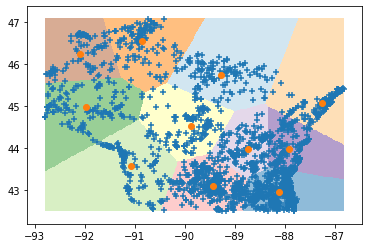

In [17]:
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(),yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='xy', alpha = 0.5)
plt.scatter(plotter['LONGITUDE'],plotter['LATITUDE'], marker = '+')
plt.scatter(centroids[:,1], centroids[:,0])
plt.show()


In [18]:
kmeans.predict([[44,-110]])

array([3], dtype=int32)

In [19]:
dfKMeans['K-cluster'] = np.array(kmeans.labels_)

In [20]:
dfKMeans.head(5)

,LATITUDE,LONGITUDE,LOCALITY,K-cluster
3,43.067967,-87.892686,Riverside Park (Urban Ecology Center),1
4,43.175688,-87.890421,Schlitz Audubon Nature Center,1
5,44.092794,-87.650170,Manitowoc Lakefront,8
15,43.077869,-89.421544,UW Lakeshore Nature Preserve--Willow Creek Woo...,4
16,43.247843,-89.429111,County V Ponds (Dane Co.),4


In [21]:
def hotspot_finder_for_kcluster(k, df, dfKMeans):
    dfIntermediate = df[df['LOCALITY'].isin(list(dfKMeans[dfKMeans['K-cluster'] == k]['LOCALITY']))].groupby(['LOCALITY','COMMON NAME']).sum().filter(['ALL SPECIES REPORTED'])
    dfIntermediate['BIRD'] = list(map(lambda x: 1 if x < 1e6 else 1, dfIntermediate['ALL SPECIES REPORTED']))
    location  =  dfIntermediate.filter(['BIRD']).reset_index().groupby(['LOCALITY']).sum().reset_index().sort_values(by='BIRD', ascending=False).reset_index()['LOCALITY'][0]
    lat = df[df['LOCALITY']==location].reset_index()['LATITUDE'][0]
    lon = df[df['LOCALITY']==location].reset_index()['LONGITUDE'][0]
    
    return location, lat, lon

In [22]:
latHotspot = np.empty((nClusters))
lonHotspot = np.empty((nClusters))

In [23]:
for i in range(0, nClusters):
    a, latHotspot[i], lonHotspot[i] = hotspot_finder_for_kcluster(i, dfTrain, dfKMeans)

# Clustering know using BDSCAN

BDSCAN is a density clustering that will tell where is popular for people to go birding (based on the desnity of hotsopts).  I will also be able to limit the scale of the cluster with a driving distance matrix form googles API.

In [24]:
dfbdscan = dfTrain.filter(['LOCALITY','LATITUDE', 'LONGITUDE'])

In [25]:
dfbdscan.drop_duplicates(subset='LATITUDE', keep = 'first', inplace = True)

In [26]:
dfbdscan.head(5)

,LOCALITY,LATITUDE,LONGITUDE
3,Riverside Park (Urban Ecology Center),43.067967,-87.892686
4,Schlitz Audubon Nature Center,43.175688,-87.890421
5,Manitowoc Lakefront,44.092794,-87.650170
15,UW Lakeshore Nature Preserve--Willow Creek Woo...,43.077869,-89.421544
16,County V Ponds (Dane Co.),43.247843,-89.429111


In [27]:
latHotspot, lonHotspot = np.array(dfbdscan['LATITUDE']), np.array(dfbdscan['LONGITUDE'])
locationList = np.empty((latHotspot.shape[0],2))
for i in range(0, dfbdscan.shape[0]):
    locationList[i,0], locationList[i,1] = latHotspot[i], lonHotspot[i]
    

In [28]:
eps = .05
dbmod = DBSCAN(eps=eps, min_samples=3, metric='euclidean').fit(locationList)

In [29]:
labels = dbmod.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
core_samples_mask = np.zeros_like(dbmod.labels_, dtype=bool)
core_samples_mask[dbmod.core_sample_indices_] = True

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)


Estimated number of clusters: 137
Estimated number of noise points: 567


In [30]:
unique_labels = set(labels)
colors = [plt.cm.viridis_r(each)
          for each in np.linspace(0, 1, len(unique_labels))]


In [31]:
# plt.scatter(locationList[:,1],locationList[:,0], color = colors[(labels[:]+1)])
# plt.show()

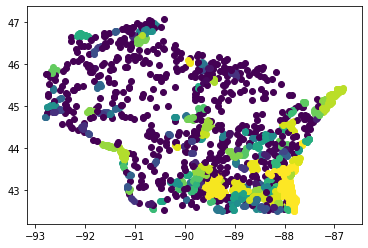

In [32]:
for i, clust in enumerate(labels):
    plt.scatter(locationList[i][1],locationList[i][0], color = colors[clust])
plt.show()

In [37]:
dfbdscan['BD CLUSTER'] = dbmod.labels_

In [38]:
dfbdscan.head(5)

,LOCALITY,LATITUDE,LONGITUDE,BD CLUSTER
3,Riverside Park (Urban Ecology Center),43.067967,-87.892686,0
4,Schlitz Audubon Nature Center,43.175688,-87.890421,0
5,Manitowoc Lakefront,44.092794,-87.650170,1
15,UW Lakeshore Nature Preserve--Willow Creek Woo...,43.077869,-89.421544,2
16,County V Ponds (Dane Co.),43.247843,-89.429111,2


In [39]:
def hotspot_finder_for_dbcluster(k, df, dfbdscan):
    dfIntermediate = dfTrain[dfTrain['LOCALITY'].isin(list(dfbdscan[dfbdscan['BD CLUSTER'] == 0]['LOCALITY']))].groupby(['LOCALITY','COMMON NAME']).sum().filter(['ALL SPECIES REPORTED'])
    dfIntermediate['BIRD'] = list(map(lambda x: 1 if x < 1e6 else 1, dfIntermediate['ALL SPECIES REPORTED']))
    location  = dfIntermediate.filter(['BIRD']).reset_index().groupby(['LOCALITY']).sum().reset_index().sort_values(by='BIRD', ascending=False).reset_index()['LOCALITY'][0]
    lat = df[df['LOCALITY']==location].reset_index()['LATITUDE'][0]
    lon = df[df['LOCALITY']==location].reset_index()['LONGITUDE'][0]
    
    return location, lat, lon

In [40]:
coorHotspot = np.empty((n_clusters_, 2))
for i in range(0, n_clusters_):
    a, coorHotspot[i, 0], coorHotspot[i, 1] = hotspot_finder_for_dbcluster(i, dfTrain, dfbdscan)

### Now some good plots

In [33]:
country = gpd.read_file('/Users/casanova/DocumentsHere/Insight/gz_2010_us_040_00_5m.json')

In [34]:
# state = 'Wyoming'
state = 'Wisconsin'

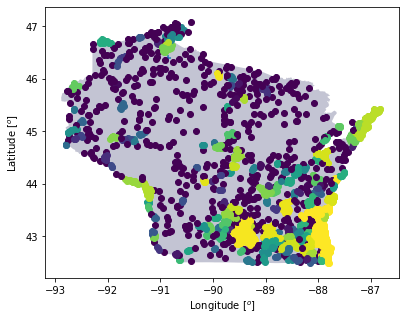

In [35]:
fig, ax = plt.subplots(1, figsize=(7,5))
base = country[country['NAME'].isin([state]) == True].plot(ax=ax, color='#3B3C6E', alpha = 0.3)
# plt.imshow(Z, interpolation='nearest',
#            extent=(xx.min(), xx.max(),yy.min(), yy.max()),
#            cmap=plt.cm.Paired,
#            aspect='auto', origin='xy', alpha = 0.5)
ax.scatter(plotter['LONGITUDE'],plotter['LATITUDE'], marker = '+')
# ax.scatter(centroids[:,1], centroids[:,0])
# ax.scatter(lonHotspot,latHotspot, marker = 'x', color = 'r', s=80)
for i, clust in enumerate(labels):
    ax.scatter(locationList[i][1],locationList[i][0], color = colors[clust])
ax.set_ylabel(r'Latitude [$^o$]')
ax.set_xlabel(r'Longitude [$^o$]')
# for i in range(centroids[:,1]):
# ax.text(-105, 44, '0', fontsize=14,verticalalignment='top')

plt.show()
save_fig('/Users/casanova/DocumentsHere/Insight/{}-plain.png'.format(state))

#### Now the bird probability.

`dfKMeans` and `dfbdscan` have the information of where each of the hotspots lay, in terms of their cluster.  Now in order to constuct a path is important to mask the probabilites of the of seeing a particular bird with T or F on a weekly basis.  This is critical in order to construc the sets.

In [45]:
# dfProb = dfTrain.merge(dfKMeans.filter(['LOCALITY','K-cluster']),
#                             left_on='LOCALITY', right_on='LOCALITY', how = 'left').filter(['COMMON NAME','ALL SPECIES REPORTED','YEAR WEEK', 'K-cluster'])

dfProb = dfTrain.merge(dfbdscan.filter(['LOCALITY','BD CLUSTER']),
                            left_on='LOCALITY', right_on='LOCALITY', how = 'left').filter(['COMMON NAME','ALL SPECIES REPORTED','YEAR WEEK', 'BD CLUSTER'])

In [46]:
dfProb.head(5)

,COMMON NAME,ALL SPECIES REPORTED,YEAR WEEK,BD CLUSTER
0,Red-eyed Vireo,1,23,0.0
1,Pine Siskin,1,32,0.0
2,Mallard,1,16,1.0
3,Mallard,1,9,2.0
4,Mallard,1,27,2.0


In [ ]:
nTime = 54
nLoc = dfKMeans['K-cluster'].unique().shape[0]
setMat = np.zeros((nTime,nLoc), dtype=object)

In [ ]:
for week in range(0,nTime):
    dfProbA = dfProb[dfProb['YEAR WEEK']== week]
    dfProb1 = dfProbA.groupby(['COMMON NAME','K-cluster']).sum().filter(['ALL SPECIES REPORTED']).reset_index()
    dfProb1.rename(columns = {'ALL SPECIES REPORTED':'POS OBS'}, inplace=True)
    dfProb2 = dfProbA.groupby(['K-cluster']).sum().filter(['ALL SPECIES REPORTED']).reset_index()
    dfProb2.rename(columns = {'ALL SPECIES REPORTED':'TOT OBS'}, inplace=True)
    dfProb3 = dfProb1.merge(dfProb2, left_on='K-cluster', right_on='K-cluster', how = 'left')
    dfProb3['POS PROB'] = dfProb3['POS OBS']/dfProb3['TOT OBS']
    for loc in range(0,nLoc):
        aa = dfProb3[dfProb3['K-cluster'] == loc]
        aa['TF aa'] = list(map(lambda x: 0 if x < 0.02 else 1, aa['POS PROB']))
        setMat[week,loc] = set(aa[aa['TF aa'] == 1]['COMMON NAME'].values)
        

In [ ]:
pickle.dump(setMat, open("./2dSetLocations.p", "wb" ))

In [ ]:
ToMakeUniverse = list(setMat.flatten())
Universe = set(e for s in ToMakeUniverse for e in s)

In [ ]:
list(Universe)

# Here we go!!!!!

First user inputs some coordinates.
Then the coordinates get translated to a k-cluster.
That give us the first set (first week)
Then we obtain the resto fo the sets. The key here is to back track a set to an actual 'x,t' entry so we can have a route.
Display in some way that list of locations!  (Probabily using the centroid maps or coordinates).

In [ ]:
userInputLat,userInputLon = 44, -110
userInput = [userInputLat,userInputLon]
print(userInput)

On the first week I most see:

In [ ]:
kmeansLoaded = pickle.load(open("./kmeansModel.p", "rb" ))
setMatLoaded = pickle.load(open("./2dSetLocations.p", "rb" ))

In [ ]:
print('you start in location:',kmeansLoaded.predict([userInput])[0])
initialLocSet = setMat[0,kmeansLoaded.predict([userInput])[0]]
print(list(initialLocSet))

The hole list of bird that we are planing to see are:

In [ ]:

ToMakeUniverse = list(setMatLoaded.flatten())
Universe = set(e for s in ToMakeUniverse for e in s)

In [ ]:
print('With a total of', len(list(Universe)), 'birds')

In [ ]:
def set_cover_mine(elements, subsets, initset):
    '''
    There is a greedy algorithm for polynomial time approximation of set covering that chooses sets according to one rule: at each stage, choose the set that contains the largest number of uncovered elements.

    
    '''
    covered = initset.copy()  
    cover = []
    listCover = []
    # Greedily add the subsets with the most uncovered points
    while covered != elements:
        subset = max(subsets, key=lambda s: len(s - covered))
        cover.append(subset)
        listCover.append(subsets.index(subset))
        covered |= subset
 
    return cover, listCover





In [ ]:
setList, locList = set_cover_mine(Universe, ToMakeUniverse, initialLocSet)


In [ ]:
locList = np.sort(locList)

In [ ]:
nTime, nLoc = setMatLoaded.shape
locMat = np.linspace(1,nTime*nLoc,nTime*nLoc).reshape(nTime,nLoc)

In [ ]:
outList = ['On week 0, you need to be at location {}'.format(kmeansLoaded.predict([userInput])[0])]
for element in locList:
    a,b = np.where(locMat == element)
    outList.append('On week {}, you need to be at location {}'.format(a[0],b[0]))
    

In [ ]:
outList

In [ ]:
gmaps = googlemaps.Client(key='')

In [ ]:
geocode_result = gmaps.geocode('1600 Amphitheatre Parkway, Mountain View, CA')

In [ ]:
geocode_result

In [ ]:
reverse_geocode_result = gmaps.reverse_geocode((40.714224, -73.961452))

In [ ]:
reverse_geocode_result

In [ ]:
distanceMatGmaps = gmaps.distance_matrix(origins = locationList, 
                                         destinations=locationList, 
                                         mode = 'driving', 
                                         units = 'metric')

In [ ]:
b = gmaps.distance_matrix(origins = [(latHotspot[0], lonHotspot[0]),
                                       (latHotspot[1], lonHotspot[1]),
                                       (latHotspot[2], lonHotspot[2]),
                                       (latHotspot[3], lonHotspot[3]),
                                       (latHotspot[4], lonHotspot[4]),
                                       (latHotspot[5], lonHotspot[5]),
                                       (latHotspot[6], lonHotspot[6]),
                                       (latHotspot[7], lonHotspot[7]),
                                       (latHotspot[8], lonHotspot[8]),
                                       (latHotspot[9], lonHotspot[9])],
                          destinations=[(latHotspot[0], lonHotspot[0]),
                                       (latHotspot[1], lonHotspot[1]),
                                       (latHotspot[2], lonHotspot[2]),
                                       (latHotspot[3], lonHotspot[3]),
                                       (latHotspot[4], lonHotspot[4]),
                                       (latHotspot[5], lonHotspot[5]),
                                       (latHotspot[6], lonHotspot[6]),
                                       (latHotspot[7], lonHotspot[7]),
                                       (latHotspot[8], lonHotspot[8]),
                                       (latHotspot[9], lonHotspot[9])],
                         mode = 'driving', units = 'metric')

In [ ]:
b

In [ ]:
b['rows']

In [ ]:
b['rows'][1]['elements'][2]['duration']['value']

In [ ]:
distMat = np.empty((10,10))

for i in range(0,10):
    for j in range(0,10):
        distMat[i,j] = b['rows'][i]['elements'][j]['duration']['value']/3600

In [ ]:
print(distMat)

In [ ]:
15391/3600